<a href="https://colab.research.google.com/github/yaskhanloo/pulseqYS/blob/main/write_bSSFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
!git clone https://github.com/yaskhanloo/pulseqYS.git

Cloning into 'pulseqYS'...


In [ ]:
!pip install pypulseq

In [1]:
import math
import numpy as np
import pypulseq as pp

Timing check passed successfully


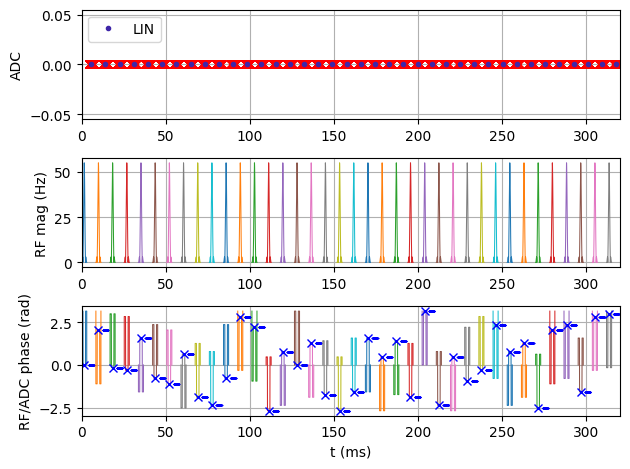

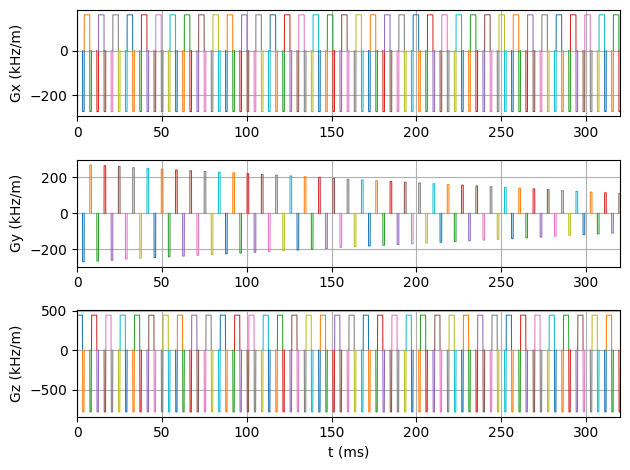

In [2]:
def main(plot: bool, write_seq: bool, seq_filename: str = "bssfp_pypulseq.seq"):
    # ======
    # SETUP
    # ======
    seq = pp.Sequence()  # Create a new sequence object
    fov = 250e-3  # Define FOV and resolution
    Nx = 128
    Ny = Nx

    alpha = 15  # Flip angle
    slice_thickness = 3e-3  # Slice thickness
    n_slices = 1
    TR = 10e-3  # Repetition time
    TE = TR / 2

    rf_spoiling_inc = 117  # RF spoiling increment
    ro_duration = 3.2e-3  # ADC duration

    # Set system limits
    system = pp.Opts(
        max_grad=28,
        grad_unit="mT/m",
        max_slew=150,
        slew_unit="T/m/s",
        rf_ringdown_time=20e-6,
        rf_dead_time=100e-6,
        adc_dead_time=10e-6,
    )

    # ======
    # CREATE EVENTS
    # ======
    # Create alpha-degree slice selection pulse and gradient
    rf, gz, _ = pp.make_sinc_pulse(
        flip_angle=alpha * np.pi / 180,
        duration=3e-3,
        slice_thickness=slice_thickness,
        apodization=0.5,
        time_bw_product=4,
        system=system,
        return_gz=True,
    )

    # Define other gradients and ADC events
    delta_k = 1 / fov
    gx = pp.make_trapezoid(
        channel="x", flat_area=Nx * delta_k, flat_time=ro_duration, system=system
    )
    adc = pp.make_adc(
        num_samples=Nx, duration=gx.flat_time, delay=gx.rise_time, system=system
    )
    gx_pre = pp.make_trapezoid(
        channel="x", area=-gx.area / 2, duration=1e-3, system=system
    )
    gz_reph = pp.make_trapezoid(
        channel="z", area=-gz.area / 2, duration=1e-3, system=system
    )
    phase_areas = -(np.arange(Ny) - Ny / 2) * delta_k

    # Gradient spoiling
    gx_spoil = pp.make_trapezoid(channel="x", area=2 * Nx * delta_k, system=system)
    gz_spoil = pp.make_trapezoid(channel="z", area=4 / slice_thickness, system=system)

    # Calculate timing
    delay_TE = (
        math.ceil(
            (
                TE
                - pp.calc_duration(gx_pre)
                - gz.fall_time
                - gz.flat_time / 2
                - pp.calc_duration(gx) / 2
            )
            / seq.grad_raster_time
        )
        * seq.grad_raster_time
    )
    delay_TR = (
        math.ceil(
            (
                TR
                - pp.calc_duration(gz)
                - pp.calc_duration(gx_pre)
                - pp.calc_duration(gx)
                - delay_TE
            )
            / seq.grad_raster_time
        )
        * seq.grad_raster_time
    )
    assert np.all(delay_TE >= 0)
    assert np.all(delay_TR >= pp.calc_duration(gx_spoil, gz_spoil))

    rf_phase = 0
    rf_inc = 0

    seq.add_block(pp.make_label(label="REV", type="SET", value=1))

    # ======
    # CONSTRUCT SEQUENCE
    # ======
    # Loop over slices
    for s in range(n_slices):
        rf.freq_offset = gz.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
        # Loop over phase encodes and define sequence blocks
        for i in range(Ny):
            rf.phase_offset = rf_phase / 180 * np.pi
            adc.phase_offset = rf_phase / 180 * np.pi
            rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]
            rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]

            seq.add_block(rf, gz)
            gy_pre = pp.make_trapezoid(
                channel="y",
                area=phase_areas[i],
                duration=pp.calc_duration(gx_pre),
                system=system,
            )
            gy_pre2 = pp.make_trapezoid(
                channel="y",
                area= (-1) * phase_areas[i],
                duration=pp.calc_duration(gx_pre),
                system=system,
            )
            seq.add_block(gx_pre, gy_pre2, gz_reph)
            seq.add_block(gx, adc)
            seq.add_block(gx_pre, gy_pre, gz_reph)

    ok, error_report = seq.check_timing()

    if ok:
        print("Timing check passed successfully")
    else:
        print("Timing check failed. Error listing follows:")
        [print(e) for e in error_report]

    # ======
    # VISUALIZATION
    # ======
    if plot:
        seq.plot(label="lin", time_range=np.array([0, 32]) * TR, time_disp="ms")

    # =========
    # WRITE .SEQ
    # =========
    if write_seq:
        # Prepare the sequence output for the scanner
        seq.set_definition(key="FOV", value=[fov, fov, slice_thickness * n_slices])
        seq.set_definition(key="Name", value="gre_label")

        seq.write(seq_filename)


if __name__ == "__main__":
    main(plot=True, write_seq=True)